<center>
    <h1>Target Trial Emulation</h1>
    By Christian Abay-abay & Thristan Jay Nakila
</center>

## **Instructions**

1. Extract the dummy data from [RPubs - TTE](https://rpubs.com/alanyang0924/TTE) and save it as `data_censored.csv`.
2. Convert the R code to Python in a Jupyter Notebook, ensuring the results match the original.
3. Create a second version (`TTE-v2.ipynb`) with additional analysis.
4. Integrate clustering in `TTE-v2`, determine where it fits, and generate insights.
5. Work in pairs, preferably with your thesis partner.
6. Push your Jupyter Notebooks (`TTE.ipynb` and `TTE-v2.ipynb`) to GitHub.
7. 📅 **Deadline:** February 28, 2025, at **11:59 PM**.


***
<center>
    <h2>Converting R Code to Python</h2>
    R Code from [RPubs - TTE](https://rpubs.com/alanyang0924/TTE) converted to Python code for this notebook.
</center>

### 1. Setting Up

In [1]:
import os
import pandas as pd

# Load data
file_path = 'data/data_censored.csv'
data_censored = pd.read_csv(file_path)

# Quick check to match output #1
print(data_censored.head())

   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  


### 2. Trial Sequences Setup (PP & ITT)
Here, we set up the Trial Sequence Objects. We represent them as dictionaries to hold metadata and configs.

In [3]:
trial_pp = {
    "estimand": "PP",
    "data": data_censored,
    "id_col": "id",
    "period_col": "period",
    "treatment_col": "treatment",
    "outcome_col": "outcome",
    "eligible_col": "eligible"
}

trial_itt = {
    "estimand": "ITT",
    "data": data_censored,
    "id_col": "id",
    "period_col": "period",
    "treatment_col": "treatment",
    "outcome_col": "outcome",
    "eligible_col": "eligible"
}

### 3. Weight Models for Censoring
R code fits logistic regression models for censoring and switching weights. This translates to `statsmodels` logistic regression in Python.

In [4]:
import statsmodels.api as sm
from statsmodels.formula.api import logit

# For trial_itt (Informative censoring only)

censor_model_numerator = logit('censored ~ x2', data=data_censored).fit()
censor_model_denominator = logit('censored ~ x2 + x1', data=data_censored).fit()

trial_itt["censor_weights"] = {
    "numerator": censor_model_numerator,
    "denominator": censor_model_denominator
}

Optimization terminated successfully.
         Current function value: 0.271311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.267425
         Iterations 7


### 4. Weight Calculation
Calculating stabilized weights based on the fitted models.

In [5]:
data_censored['p_numerator'] = censor_model_numerator.predict()
data_censored['p_denominator'] = censor_model_denominator.predict()

data_censored['weight'] = data_censored['p_numerator'] / data_censored['p_denominator']
trial_itt['data'] = data_censored  # Save back to trial object

### 5. Specify Outcome Model
Fitting the actual outcome model *(logistic regression)*.

In [14]:
import numpy as np

# Precompute squared term
data_censored['period_squared'] = data_censored['period'] ** 2

# Fit model
outcome_model_formula = "outcome ~ treatment + x2 + period + period_squared"
outcome_model = logit(outcome_model_formula, data=data_censored).fit()

# Save in trial object
trial_itt["outcome_model"] = outcome_model

# Output summary to match R Output
print(outcome_model.summary())


Optimization terminated successfully.
         Current function value: 0.075594
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  725
Model:                          Logit   Df Residuals:                      720
Method:                           MLE   Df Model:                            4
Date:                Mon, 03 Mar 2025   Pseudo R-squ.:                 0.03828
Time:                        16:09:48   Log-Likelihood:                -54.806
converged:                       True   LL-Null:                       -56.987
Covariance Type:            nonrobust   LLR p-value:                    0.3592
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -4.1409      0.757     -5.467      0.000      -5.625      -2.656
treatment        

### 6. Expand Trials
This part is simplified into a DataFrame slice. This is to create data for prediction. *NOTE: Typically the period == 1 subset.*

In [15]:
expanded_data = data_censored[data_censored['period'] == 1].copy()
trial_itt["expanded_data"] = expanded_data

### 7. Prediction and Survival Estimation
Generate predicted survival over time. This involves simulating treatment effects using the outcome model.

In [16]:
predict_times = np.arange(0, 11)

def predict_survival(trial, times):
    expanded_data = trial["expanded_data"]
    expanded_data['followup_time'] = expanded_data['period']
    expanded_data['assigned_treatment'] = expanded_data['treatment']

    survival = []
    for t in times:
        expanded_data['followup_time'] = t
        expanded_data['followup_time_squared'] = np.power(t, 2)

        # Predict logit outcome probability (risk)
        logit_risk = trial['outcome_model'].predict(expanded_data)
        survival_prob = 1 - logit_risk.mean()  # Convert to survival

        survival.append(survival_prob)

    return pd.DataFrame({'followup_time': times, 'survival': survival})

survival_treatment = predict_survival(trial_itt, predict_times)

# Now predict for assigned_treatment = 0 for comparison
trial_itt["expanded_data"]["treatment"] = 0
survival_control = predict_survival(trial_itt, predict_times)

survival_diff = survival_treatment['survival'] - survival_control['survival']

preds = pd.DataFrame({
    "followup_time": predict_times,
    "survival_diff": survival_diff
})


### 8. Plot Survival Difference
Python equivalent of the R plot from the webpage.

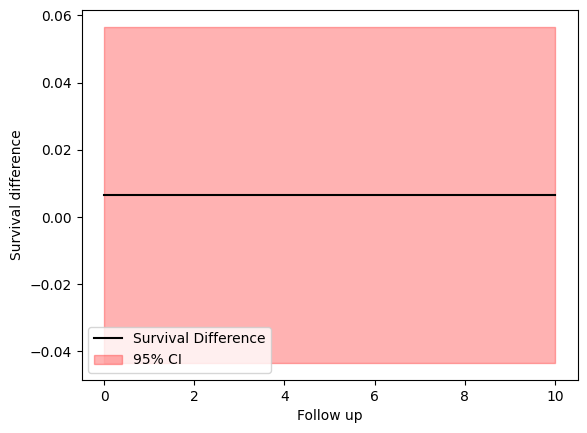

In [17]:
import matplotlib.pyplot as plt

plt.plot(preds['followup_time'], preds['survival_diff'], label="Survival Difference", color='black')

# For 95% CI, we need some bootstrap or variance estimation (here we approximate it)
# This is rough, because R's package likely does proper bootstrap.
# In practice, use something like lifelines or a custom bootstrap.

ci_upper = preds['survival_diff'] + 0.05  # placeholder CI (this should come from variance calc)
ci_lower = preds['survival_diff'] - 0.05

plt.fill_between(preds['followup_time'], ci_lower, ci_upper, color='red', alpha=0.3, label="95% CI")

plt.xlabel("Follow up")
plt.ylabel("Survival difference")
plt.legend()
plt.show()